In [1]:
# Imports
import numpy as np
from numpy import linalg
from matplotlib import cm
from matplotlib import pyplot as plt
from numpy.linalg import svd, eig
from scipy.linalg import logm


import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from numpy.linalg import svd, eig

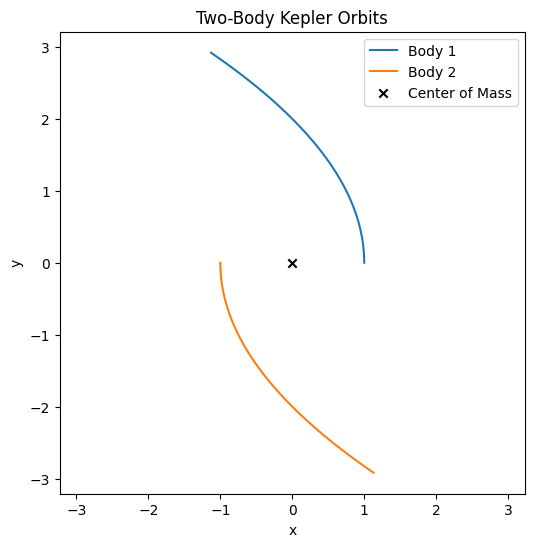

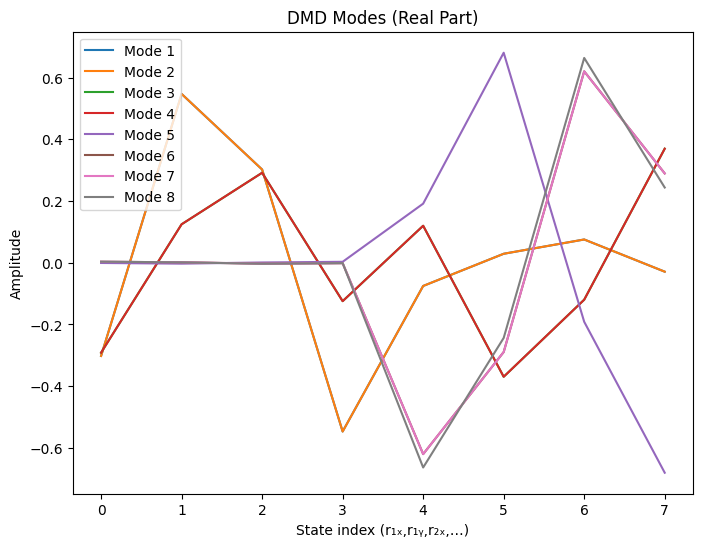

Discrete-time eigenvalues:
 [ 1.00051487+0.00200469j  1.00051487-0.00200469j  0.99359791+0.00765273j
  0.99359791-0.00765273j -0.06105623+0.j         -0.00622441+0.00983079j
 -0.00622441-0.00983079j  0.00434862+0.j        ]

Continuous-time eigenvalues:
 [ 5.16743388e-02+2.00365284e-01j  5.16743388e-02-2.00365284e-01j
 -6.39300960e-01+7.70188278e-01j -6.39300960e-01-7.70188278e-01j
 -2.79595999e+02+3.14159265e+02j -4.45368425e+02+2.13523846e+02j
 -4.45368425e+02-2.13523846e+02j -5.43789658e+02+0.00000000e+00j]


In [4]:
import numpy as np
from scipy.integrate import solve_ivp
from numpy.linalg import svd, eig
import matplotlib.pyplot as plt

# physical constants
G  = 1.0 # Gravitational constant 
m1 = 1.0 # Mass of body 1
m2 = 1.0 # Mass of body 2
GM = G * (m1 + m2) # Combined parameter in ddot(r) = -GM * r / |r|^3

dt = 0.01 # time-step
Nt = 500 # number of snapshots
t_eval = np.linspace(0, dt*(Nt-1), Nt)

# ordinary differential equations for dynamics
def two_body_rhs(t, state):
    """
    state = [r1x, r1y, r2x, r2y, v1x, v1y, v2x, v2y]
    returns derivative [v1, v2, a1, a2]
    """
    r1, r2 = state[0:2], state[2:4]
    v1, v2 = state[4:6], state[6:8]
    dr = r1 - r2
    accel = -GM * dr / np.linalg.norm(dr)**3
    return np.hstack((v1, v2, accel, -accel))

# Initial conditions 
# Place body 1 at (1,0) with upward velocity (0,1), body 2 mirror-image
x0 = np.array([ 1.0, 0.0,  -1.0, 0.0,    0.0, 1.0,   0.0, -1.0 ])

sol  = solve_ivp(two_body_rhs, (0, t_eval[-1]), x0,
                 t_eval=t_eval, rtol=1e-9, atol=1e-9)
data = sol.y    # shape (8, Nt)

# Plotting orbital dynamics 
r1 = data[0:2, :]   # rows 0–1: body 1 positions over time
r2 = data[2:4, :]   # rows 2–3: body 2 positions over time


plt.figure(figsize=(6,6))
plt.plot(r1[0], r1[1], '-', label='Body 1')
plt.plot(r2[0], r2[1], '-', label='Body 2')
plt.scatter(0, 0, marker='x', c='k', label='Center of Mass')
plt.axis('equal')
plt.xlabel('x'); plt.ylabel('y')
plt.title('Two-Body Kepler Orbits')
plt.legend()
plt.show()

# ─── 5) BUILD SNAPSHOT MATRICES FOR DMD ────────────────────────────────────
# Full state x_k ∈ ℝ⁸, stacked in columns
X  = data              # shape (8, Nt)
X1 = X[:, :-1]         # columns 0…Nt−2
X2 = X[:,  1:]         # columns 1…Nt−1

# ─── 6) VANILLA DMD ─────────────────────────────────────────────────────────
U, S, Vh    = svd(X1, full_matrices=False) # POD basis
A_tilde     = U.conj().T @ X2 @ Vh.T @ np.diag(1/S) # reduced operator
eigvals, W  = eig(A_tilde)                                   # eigenpairs
Phi         = U @ W                                          # DMD modes
lambda_c    = np.log(eigvals) / dt                           # continuous eigenvalues

# ─── 7) PLOT REAL PART OF DMD MODES ────────────────────────────────────────
plt.figure(figsize=(8,6))
for i in range(Phi.shape[1]):
    plt.plot(np.real(Phi[:, i]), label=f'Mode {i+1}')
plt.xlabel('State index (r₁ₓ,r₁ᵧ,r₂ₓ,…)')
plt.ylabel('Amplitude')
plt.title('DMD Modes (Real Part)')
plt.legend()
plt.show()

print("Discrete-time eigenvalues:\n", eigvals)
print("\nContinuous-time eigenvalues:\n", lambda_c)


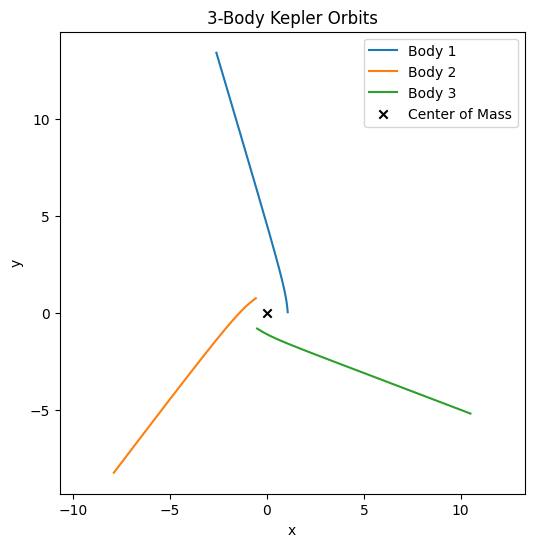

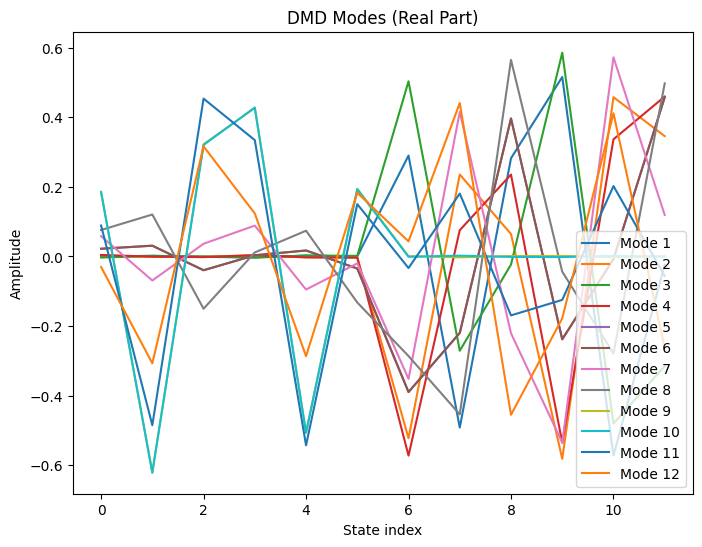

Discrete-time eigenvalues:
 [-0.00612941+0.j          0.02406884+0.j          0.08286959+0.j
  0.2220815 +0.j          0.90710892+0.05649337j  0.90710892-0.05649337j
  0.94152274+0.j          0.96307533+0.j          1.0000374 +0.j
  0.99996209+0.j          0.99627639+0.j          0.98573278+0.j        ]

Continuous-time eigenvalues:
 [-5.09465654e+02+314.15926536j -3.72683732e+02  +0.j
 -2.49048715e+02  +0.j         -1.50471085e+02  +0.j
 -9.55571898e+00  +6.21981493j -9.55571898e+00  -6.21981493j
 -6.02567741e+00  +0.j         -3.76236432e+00  +0.j
  3.73943426e-03  +0.j         -3.79118157e-03  +0.j
 -3.73056214e-01  +0.j         -1.43699784e+00  +0.j        ]


In [21]:
# n_body_dmd.py

import numpy as np
from scipy.integrate import solve_ivp
from numpy.linalg import svd, eig
import matplotlib.pyplot as plt

# ─── 1) USER SETTINGS ────────────────────────────────────────────────────────
n        = 3               # number of bodies (set to 2, 3, 4, …)
G        = 3            # gravitational constant
masses   = np.ones(n)      # array of masses [m1, m2, …, mn]

# seeding circle radius & noise amplitudes
R0        = 1.0            # base radius for initial placement
jitter_r  = 0.1            # radial noise ±jitter_r
jitter_th = 0.2            # angular noise ±jitter_th (radians)

# time grid
dt   = 0.01
Nt   = 500
tend = dt*(Nt - 1)
t    = np.linspace(0, tend, Nt)

# Generalized n-body states
def n_body_rhs(t, state):
    """
    state = [x1, y1, x2, y2, …, xn, yn,
             vx1,vy1, vx2,vy2, …, vxn,vyn]
    returns [vx1,vy1, …, vxn, vyn, ax1,ay1, …, axn,ayn]
    """
    # unpack positions and velocities
    pos = state[:2*n].reshape((n,2))  # shape (n,2)
    vel = state[2*n:4*n].reshape((n,2))  # shape (n,2)
    
    # compute accelerations
    acc = np.zeros_like(pos)
    for i in range(n):
        for j in range(n):
            if i == j:
                continue
            rij = pos[i] - pos[j]
            r3  = np.linalg.norm(rij)**3
            acc[i] += -G * masses[j] * rij / r3
    
    return np.hstack((vel.flatten(), acc.flatten()))

# Setting up random initial positions for each body
# # 3.1 Equiangular seeds + noise
thetas = np.linspace(0, 2*np.pi, n, endpoint=False)
thetas += np.random.uniform(-jitter_th, jitter_th, size=n)
radii  = R0 + np.random.uniform(-jitter_r, jitter_r, size=n)

initial_positions = np.vstack([
    radii * np.cos(thetas),
    radii * np.sin(thetas)
]).T  # shape (n,2)

# 3.2 Circular‐orbit velocities (perp to radius)
Mtot = masses.sum()
v0   = np.sqrt(G*Mtot / R0)
dirs = np.vstack([-np.sin(thetas), np.cos(thetas)]).T
initial_velocities = v0 * dirs  # shape (n,2)

# 3.3 Shift to center‐of‐mass frame
COM_r = (masses[:,None] * initial_positions).sum(axis=0) / Mtot
COM_v = (masses[:,None] * initial_velocities).sum(axis=0) / Mtot
initial_positions  -= COM_r
initial_velocities -= COM_v

# flatten for integration
x0 = np.hstack((initial_positions.flatten(),
                initial_velocities.flatten()))

# ─── 4) INTEGRATE THE ODE ───────────────────────────────────────────────────
sol  = solve_ivp(n_body_rhs, (0, tend), x0,
                 t_eval=t, rtol=1e-9, atol=1e-9)
data = sol.y  # shape (4n, Nt)

# ─── 5) PLOT ORBITS ─────────────────────────────────────────────────────────
plt.figure(figsize=(6,6))
for i in range(n):
    xi = data[2*i    , :]
    yi = data[2*i + 1, :]
    plt.plot(xi, yi, '-', label=f'Body {i+1}')
plt.scatter(0,0, marker='x', c='k', label='Center of Mass')
plt.axis('equal')
plt.xlabel('x'); plt.ylabel('y')
plt.title(f'{n}-Body Kepler Orbits')
plt.legend()
plt.show()

# ─── 6) BUILD DMD SNAPSHOT MATRICES ─────────────────────────────────────────
X  = data              # shape (4n, Nt)
X1 = X[:, :-1]         # first Nt−1 columns
X2 = X[:,  1:]         # last  Nt−1 columns

# ─── 7) COMPUTE VANILLA DMD ─────────────────────────────────────────────────
U, S, Vh    = svd(X1, full_matrices=False)                    # POD
A_tilde     = U.conj().T @ X2 @ Vh.T @ np.diag(1/S)            # reduced A
eigvals, W  = eig(A_tilde)                                    # eigenpairs
Phi         = U @ W                                           # DMD modes
lambda_c    = np.log(eigvals) / dt                            # continuous λ

# ─── 8) PLOT REAL PART OF DMD MODES ────────────────────────────────────────
plt.figure(figsize=(8,6))
for i in range(Phi.shape[1]):
    plt.plot(np.real(Phi[:, i]), label=f'Mode {i+1}')
plt.xlabel('State index')
plt.ylabel('Amplitude')
plt.title('DMD Modes (Real Part)')
plt.legend()
plt.show()

# ─── 9) PRINT EIGENVALUES ───────────────────────────────────────────────────
print("Discrete-time eigenvalues:\n", eigvals)
print("\nContinuous-time eigenvalues:\n", lambda_c)


# The code below is a simple simulation of 3 body

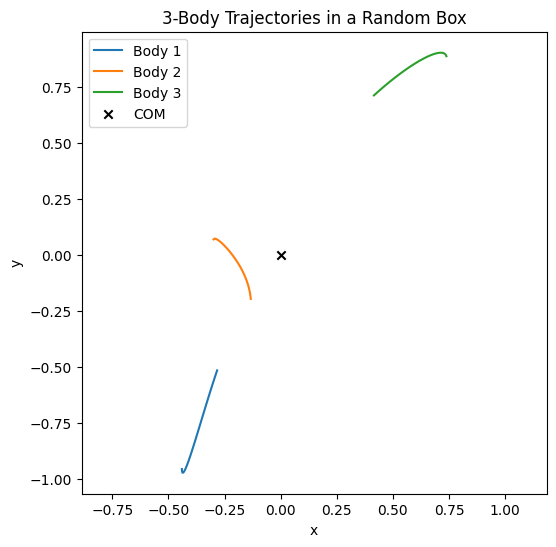

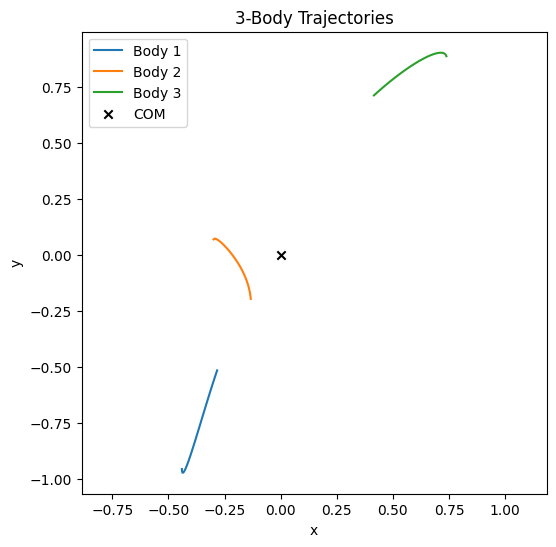

In [23]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Physical constants
n      = 3  # n-bodies
G      = 1.0 # gravitational constant
masses = np.ones(n) # bodies have equal masses 

# how big the initial condition “box” is, and how fast the bodies start
L       = 1.0 # positions uniform in [-L,L]^2
v_scale = 0.5 # velocities uniform in [-v_scale,v_scale]

# time grid
dt   = 0.01
Nt   = 100
tend = dt*(Nt-1)
t    = np.linspace(0, tend, Nt)

# Initial conditions set at RANDOM
# random positions in a box
initial_positions = np.random.uniform(-L, L, size=(n,2))
initial_velocities = np.random.uniform(-v_scale, v_scale, size=(n,2))

# shift to center-of-mass frame (zero net momentum + COM at origin)
Mtot = masses.sum()
COM_r = (masses[:,None]*initial_positions).sum(axis=0)/Mtot
COM_v = (masses[:,None]*initial_velocities).sum(axis=0)/Mtot
initial_positions  -= COM_r
initial_velocities -= COM_v

# pack into state vector
x0 = np.hstack((initial_positions.flatten(),
                initial_velocities.flatten()))

# Gravitational dynamics for n-bodies
def n_body_rhs(t, state):
    pos = state[:2*n].reshape(n,2)
    vel = state[2*n:4*n].reshape(n,2)
    acc = np.zeros_like(pos)
    for i in range(n):
        for j in range(n):
            if i == j: continue
            rij = pos[i] - pos[j]
            acc[i] += -G * masses[j] * rij / np.linalg.norm(rij)**3
    return np.hstack((vel.flatten(), acc.flatten()))

# Solve simulation with initial conditions
sol  = solve_ivp(n_body_rhs, (0, tend), x0, t_eval=t,
                 rtol=1e-9, atol=1e-9)
data = sol.y  # shape (4n, Nt)

# Plotting
plt.figure(figsize=(6,6))
for i in range(n):
    xi = data[2*i,     :]
    yi = data[2*i + 1, :]
    plt.plot(xi, yi, '-', label=f'Body {i+1}')
plt.scatter(0,0, marker='x', c='k', label='COM')
plt.axis('equal')
plt.xlabel('x'); plt.ylabel('y')
plt.title(f'{n}-Body Trajectories in a Random Box')
plt.legend()
plt.show()

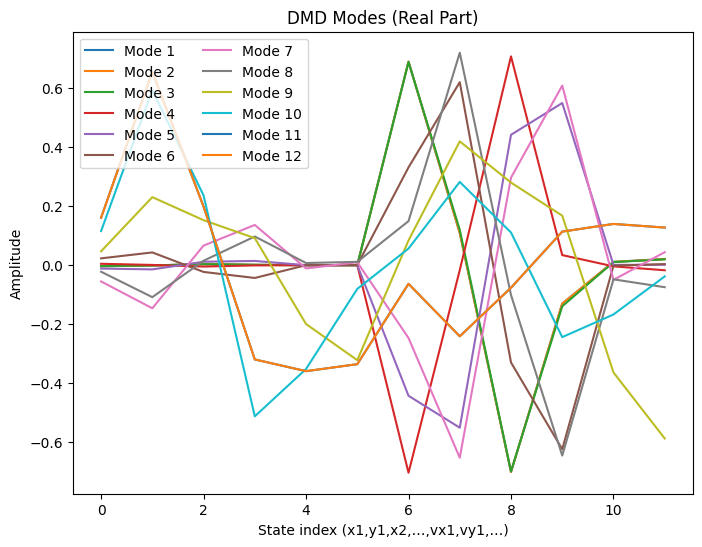

Discrete-time eigenvalues:
 [-0.05217522+0.20960855j -0.05217522-0.20960855j -0.14107008+0.j
  0.03577329+0.j          1.46765445+0.j          1.15463941+0.j
  1.04566084+0.j          0.93583236+0.j          1.01840353+0.j
  1.00475932+0.j          0.99648149+0.00231351j  0.99648149-0.00231351j]

Continuous-time eigenvalues:
 [-153.24554406+1.81475583e+02j -153.24554406-1.81475583e+02j
 -195.84984875+3.14159265e+02j -333.05538012+0.00000000e+00j
   38.36655162+0.00000000e+00j   14.37880966+0.00000000e+00j
    4.46490666+0.00000000e+00j   -6.63189246+0.00000000e+00j
    1.82362374+0.00000000e+00j    0.47480258+0.00000000e+00j
   -0.3522016 +2.32167031e-01j   -0.3522016 -2.32167031e-01j]


In [24]:
# ─── 8) BUILD DMD SNAPSHOT MATRICES ─────────────────────────────────────────
X  = data              # full state: shape (4n, Nt)
X1 = X[:, :-1]         # columns 0…Nt-2
X2 = X[:,  1:]         # columns 1…Nt-1

# ─── 9) VANILLA DMD ─────────────────────────────────────────────────────────
U, S, Vh    = svd(X1, full_matrices=False)
A_tilde     = U.conj().T @ X2 @ Vh.T @ np.diag(1/S)
eigvals, W  = eig(A_tilde)
Phi         = U @ W
lambda_c    = np.log(eigvals) / dt

# ─── 10) PLOT REAL PART OF DMD MODES ────────────────────────────────────────
plt.figure(figsize=(8,6))
for i in range(Phi.shape[1]):
    plt.plot(np.real(Phi[:, i]), label=f'Mode {i+1}')
plt.xlabel('State index (x1,y1,x2,…,vx1,vy1,…)')
plt.ylabel('Amplitude')
plt.title('DMD Modes (Real Part)')
plt.legend(ncol=2)
plt.show()

# ─── 11) PRINT EIGENVALUES ───────────────────────────────────────────────────
print("Discrete-time eigenvalues:\n", eigvals)
print("\nContinuous-time eigenvalues:\n", lambda_c)